# 卷积神经网络：逐步实现

在本程序中，你将使用 **numpy** 来实现卷积层（CONV）和池化层（POOL），包括前向传播和反向传播。

**符号说明**：
- 上标 $[l]$ 表示第 $l$ 层的对象。  
  - 例子：$a^{[4]}$ 表示第4层的激活值；$W^{[5]}$ 和 $b^{[5]}$ 表示第5层的参数。

- 上标 $(i)$ 表示第 $i$ 个样本的对象。  
  - 例子：$x^{(i)}$ 表示第 $i$ 个训练样本的输入。

- 下标 $i$ 表示向量的第 $i$ 个元素。  
  - 例子：$a^{[l]}_i$ 表示第 $l$ 层激活值中的第 $i$ 个分量（假设这是一个全连接层）。

- $n_H$、$n_W$ 和 $n_C$ 分别表示某一层的高度、宽度和通道数。  
  如果要引用特定的第 $l$ 层，可以写作 $n_H^{[l]}$、$n_W^{[l]}$、$n_C^{[l]}$。  

- $n_{H_{prev}}$、$n_{W_{prev}}$ 和 $n_{C_{prev}}$ 分别表示前一层的高度、宽度和通道数。  
  如果引用特定的第 $l$ 层，可以写作 $n_H^{[l-1]}$、$n_W^{[l-1]}$、$n_C^{[l-1]}$。  

我们假设你已经熟悉 `numpy`，并且完成了前面课程的学习。现在让我们开始吧！


## 1 - 包

我们先导入在本作业中需要用到的所有包。  
- [numpy](www.numpy.org) 是 Python 中进行科学计算的基础包。  
- [matplotlib](http://matplotlib.org) 是 Python 中用于绘图的库。  
- `np.random.seed(1)` 用于保持所有随机函数调用的一致性，这将有助于我们对你的作业进行评分。


In [1]:
# ==============================
# 导入必要的库
# ==============================

import numpy as np  
# 导入 NumPy 库，用于高效的数值计算和矩阵运算
# np 是 NumPy 的常用别名

import h5py  
# 导入 h5py 库，用于读取和写入 HDF5 文件格式（常用于存储大规模数据集）

import matplotlib.pyplot as plt  
# 导入 Matplotlib 库的 pyplot 模块，用于绘图
# plt 是 pyplot 模块的常用别名

# ==============================
# 配置 Matplotlib 绘图
# ==============================

%matplotlib inline  
# Jupyter Notebook 魔法命令
# 用于在 Notebook 内部直接显示绘制的图像，而不是弹出新的窗口

plt.rcParams['figure.figsize'] = (5.0, 4.0)  
# 设置绘图默认大小
# figure.figsize 参数表示图像的宽度和高度，单位为英寸 (inch)
# 这里设置为宽 5.0 inch，高 4.0 inch

plt.rcParams['image.interpolation'] = 'nearest'  
# 设置图像显示的插值方式
# 'nearest' 表示不进行插值，保持像素原始显示效果

plt.rcParams['image.cmap'] = 'gray'  
# 设置图像默认颜色映射（colormap）为灰度图
# 适合显示单通道灰度图像，例如黑白图

# ==============================
# 自动重新加载模块
# ==============================

%load_ext autoreload  
# Jupyter Notebook 魔法命令
# 加载 autoreload 扩展，用于自动重新加载外部导入的 Python 模块
# 方便在调试或修改模块后立即生效，无需重启 Notebook

%autoreload 2  
# 配置 autoreload 行为
# 2 表示对所有导入的模块都自动重新加载
# 当模块的源代码修改后，下次调用时会自动生效

# ==============================
# 设置随机数种子
# ==============================

np.random.seed(1)  
# 设置 NumPy 随机数生成器的种子
# 目的是保证随机数的可复现性
# 同样的代码每次运行都会生成相同的随机数序列


## 2 - 作业大纲

在本作业中，你将实现卷积神经网络的基本构建模块！  
你要实现的每个函数都会附带详细的说明，引导你逐步完成实现：

- 卷积相关函数，包括：
  - 零填充（Zero Padding）
  - 卷积窗口（Convolve window）
  - 卷积前向传播（Convolution forward）
  - 卷积反向传播（可选，Convolution backward）

- 池化相关函数，包括：
  - 池化前向传播（Pooling forward）
  - 创建掩码（Create mask）
  - 值分配（Distribute value）
  - 池化反向传播（可选，Pooling backward）

在本Notebook中，你将用 `numpy` 从零开始实现这些函数。  
在下一个Notebook中，你将使用PyTorch中对应的函数来构建如下模型：

<img src="images/model.png" style="width:800px;height:300px;">

**注意**：对于每一个前向传播函数，都有一个对应的反向传播函数。  
因此，在实现每一步前向传播模块时，你都需要在缓存（cache）中存储一些参数，这些参数会在反向传播计算梯度时使用。


## 3 - 卷积神经网络

尽管编程框架让卷积的使用变得很简单，但卷积仍然是深度学习中最难理解的概念之一。  
一个卷积层会将输入体（input volume）转换为一个不同大小的输出体（output volume），如下图所示：

<img src="images/conv_nn.png" style="width:350px;height:200px;">

在这一部分中，你将逐步构建卷积层的各个步骤。  
你将首先实现两个辅助函数：  
- 一个用于实现零填充（zero padding）；  
- 另一个用于计算卷积操作本身。


### 3.1 - 零填充（Zero-Padding）

零填充会在图像的边界周围补充零值：

<img src="images/PAD.png" style="width:600px;height:400px;">
<caption><center> <u> <font color='purple'> **图1** </u><font color='purple'> ：**零填充** <br> 一个具有3个通道（RGB）的图像，填充大小为2。 </center></caption>

零填充的主要好处如下：

- 它允许你在使用卷积层（CONV layer）时，不必让特征图的高度和宽度缩小。  
  这对构建更深的网络非常重要，否则随着层数增加，图像的高度和宽度会逐渐缩小。  
  一个重要的特例就是 **“same” 卷积**，在这种情况下，经过一层卷积后，高度和宽度保持不变。  

- 它帮助我们保留更多图像边界处的信息。  
  如果没有填充，在下一层中，只有极少的值会受到图像边缘像素的影响。

**练习**：实现下面的函数，它将一个批次中的所有图像都用零进行填充。  
请使用 [np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html)。  

例如，如果你想对一个形状为 $(5,5,5,5,5)$ 的数组 `a` 进行填充：  
- 在第2维上填充 `pad = 1`  
- 在第4维上填充 `pad = 3`  
- 其他维度不填充  

那么你需要这样写：  
```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), 'constant',``` constant_values=(..,..))


In [8]:
# ==============================
# 定义函数：zero_pad
# ==============================

def zero_pad(X, pad):
    """
    对输入的图像批次 X 进行零填充（zero padding）。
    填充只作用在图像的高度和宽度维度上。
    
    参数：
    X -- numpy 数组，形状为 (m, n_H, n_W, n_C)
         m：样本数量（即图像数量）
         n_H：图像高度
         n_W：图像宽度
         n_C：图像通道数（例如 3 表示 RGB）
         
    pad -- 整数，每张图像在上下左右的填充像素数
    
    返回：
    X_pad -- 填充后的图像数组，形状为 (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    # ------------------------------
    # 使用 numpy.pad 对图像进行填充
    # ------------------------------
    X_pad = np.pad(
        X,  # 需要填充的数组
        
        # pad_width 参数：每个维度的填充规则
        (
            (0, 0),       # 第 0 维：样本数 m，不填充
            (pad, pad),   # 第 1 维：图像高度 n_H，上下各填充 pad 个像素
            (pad, pad),   # 第 2 维：图像宽度 n_W，左右各填充 pad 个像素
            (0, 0)        # 第 3 维：通道数 n_C，不填充
        ),
        
        # mode 参数：填充方式
        'constant',  # 表示使用常数值填充
        
        # constant_values 参数：填充的常数值
        constant_values=0  # 用 0 填充，即零填充
    )
    
    # 返回填充后的图像数组
    return X_pad


x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


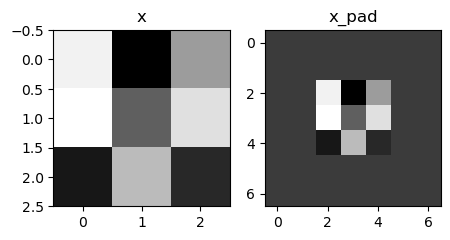

In [10]:
# ==============================
# 设置随机数种子，保证可复现
# ==============================
np.random.seed(1)  
# 设置 NumPy 随机数生成器种子为 1
# 确保每次生成的随机数序列相同

# ==============================
# 生成随机输入数据 x
# ==============================
x = np.random.randn(4, 3, 3, 2)  
# np.random.randn 生成标准正态分布随机数
# 形状为 (4, 3, 3, 2)
# 4：样本数（即 4 张图像）
# 3：图像高度
# 3：图像宽度
# 2：通道数（每张图像有 2 个通道，例如模拟 RGB 的前两个通道或特征图）

# ==============================
# 对 x 进行零填充
# ==============================
x_pad = zero_pad(x, 2)  
# 调用之前定义的 zero_pad 函数
# pad 参数为 2，表示在图像高度和宽度的每一边都填充 2 个零
# 返回填充后的数组 x_pad，形状应为 (4, 3+2*2, 3+2*2, 2) = (4,7,7,2)

# ==============================
# 打印输入和填充后的形状信息
# ==============================
print("x.shape =", x.shape)  
# 打印原始数组 x 的形状
# 期望输出：(4, 3, 3, 2)

print("x_pad.shape =", x_pad.shape)  
# 打印填充后的数组 x_pad 的形状
# 期望输出：(4, 7, 7, 2)

# ==============================
# 打印部分内容查看
# ==============================
print("x[1,1] =", x[1,1])  
# 打印第 2 张图像（索引 1）第 2 行（索引 1）所有列和通道的数据
# 用于查看原始图像的中间部分

print("x_pad[1,1] =", x_pad[1,1])  
# 打印填充后第 2 张图像（索引 1）第 2 行的数据
# 注意由于填充了 2 行零，x_pad 的行索引对应原图像内容会向下、向右偏移
# 有助于理解填充效果

# ==============================
# 可视化原始图像和填充后的图像
# ==============================
fig, axarr = plt.subplots(1, 2)  
# 创建 1 行 2 列的子图
# fig 表示整个图像窗口
# axarr 是子图数组，axarr[0] 和 axarr[1] 分别对应左图和右图

axarr[0].set_title('x')  
# 设置左图标题为 'x'（原图像）

axarr[0].imshow(x[0,:,:,0])  
# 显示第 1 张图像（索引 0）的第 1 个通道（索引 0）
# imshow 默认显示二维矩阵为灰度图（之前设置了 plt.rcParams['image.cmap'] = 'gray'）

axarr[1].set_title('x_pad')  
# 设置右图标题为 'x_pad'（填充后的图像）

axarr[1].imshow(x_pad[0,:,:,0])  
# 显示第 1 张填充后的图像的第 1 个通道
# 便于直观比较填充效果


**Expected Output**:

<table>
    <tr>
        <td>
            **x.shape**:
        </td>
        <td>
           (4, 3, 3, 2)
        </td>
    </tr>
        <tr>
        <td>
            **x_pad.shape**:
        </td>
        <td>
           (4, 7, 7, 2)
        </td>
    </tr>
        <tr>
        <td>
            **x[1,1]**:
        </td>
        <td>
           [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
        </td>
    </tr>
        <tr>
        <td>
            **x_pad[1,1]**:
        </td>
        <td>
           [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
        </td>
    </tr>

</table>

### 3.2 - 单步卷积（Single step of convolution）

在这一部分，你将实现卷积的单步操作，即将滤波器应用到输入的单个位置。  
这个步骤用于构建卷积单元（convolutional unit），该单元会：

- 接收一个输入体（input volume）  
- 在输入的每个位置应用滤波器  
- 输出另一个体（通常大小不同）

<img src="images/Convolution_schematic.gif" style="width:500px;height:300px;">
<caption><center> <u> <font color='purple'> **图2** </u><font color='purple'> ：**卷积操作** <br> 使用 2x2 的滤波器，步幅为1（stride = 每次滑动窗口的移动量） </center></caption>

在计算机视觉应用中，左侧矩阵中的每个值对应一个像素值。  
我们用一个 3x3 的滤波器与图像进行卷积：先逐元素相乘，然后将结果求和。  
在本练习的第一步，你将实现卷积的单步操作，即将滤波器应用到输入的一个位置，从而得到一个单一的实数输出。

在本Notebook后续部分，你将把这个函数应用到输入的多个位置，以实现完整的卷积操作。

**练习**：实现 `conv_single_step()` 函数。  
[提示](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.sum.html)。


In [13]:
# ==============================
# 定义函数：conv_single_step
# ==============================


def conv_single_step(a_slice_prev, W, b):
    """
    对输入数据的一个小片段（slice）应用一个卷积核（filter）。
    这是卷积操作中的单步计算，用于计算输出特征图的一个位置。

    参数：
    a_slice_prev -- 输入数据的一个切片，形状为 (f, f, n_C_prev)
                    f：卷积核的高度和宽度（假设是正方形）
                    n_C_prev：上一层的通道数（输入特征图通道数）
    
    W -- 卷积核权重参数，形状为 (f, f, n_C_prev)
         对应 a_slice_prev 的每个元素都有一个权重
    
    b -- 偏置参数，形状为 (1, 1, 1)
         卷积核对应的偏置，用于每个卷积核输出位置
    
    返回：
    Z -- 标量，卷积结果
         对 a_slice_prev 与 W 对应元素相乘并加上偏置后的求和结果
    """

    # ==============================
    # 对应元素相乘并加偏置
    # ==============================
    s = np.multiply(a_slice_prev, W) + b
    # np.multiply(a_slice_prev, W) 对应位置逐元素相乘
    # 再加上偏置 b
    # 此时 s 仍然是一个三维矩阵，形状为 (f, f, n_C_prev)

    # ==============================
    # 对 s 中所有元素求和得到卷积结果
    # ==============================
    Z = np.sum(s)
    # np.sum(s) 将 s 中所有元素累加，得到一个标量
    # 这就是卷积在当前位置的输出值

    # ==============================
    # 返回卷积结果
    # ==============================
    return Z


In [15]:
# ==============================
# 设置随机数种子，保证可复现
# ==============================
np.random.seed(1)  
# 设置 NumPy 随机数生成器种子为 1
# 确保每次生成的随机数序列相同

# ==============================
# 生成输入数据切片 a_slice_prev
# ==============================
a_slice_prev = np.random.randn(4, 4, 3)  
# np.random.randn 生成标准正态分布随机数
# 形状为 (4, 4, 3)
# 4x4 表示卷积核大小 f=4
# 3 表示输入通道数 n_C_prev=3
# 用于模拟上一层输出的一个小片段

# ==============================
# 生成卷积核权重 W
# ==============================
W = np.random.randn(4, 4, 3)  
# np.random.randn 生成标准正态分布随机数
# 形状与 a_slice_prev 相同 (4, 4, 3)
# 用于卷积核权重参数

# ==============================
# 生成卷积偏置 b
# ==============================
b = np.random.randn(1, 1, 1)  
# 偏置参数，形状为 (1, 1, 1)
# 每个卷积核有一个对应的偏置值

# ==============================
# 调用 conv_single_step 进行卷积计算
# ==============================
Z = conv_single_step(a_slice_prev, W, b)  
# 计算卷积核在 a_slice_prev 上的单步输出
# 返回标量 Z

# ==============================
# 打印卷积结果
# ==============================
print("Z =", Z)  
# 输出卷积结果
# Z 是一个标量，表示该卷积核在该切片的响应值


Z = -23.16021220252078


**Expected Output**:
<table>
    <tr>
        <td>
            **Z**
        </td>
        <td>
            -23.1602122025
        </td>
    </tr>

</table>

### 3.3 - 卷积神经网络 - 前向传播（Forward pass）

在前向传播中，你将使用多个滤波器对输入进行卷积。  
每次卷积都会产生一个二维矩阵输出，然后将这些输出堆叠起来，得到一个三维体（3D volume）：

<center>
<video width="620" height="440" src="images/conv_kiank.mp4" type="video/mp4" controls>
</video>
</center>

**练习**：实现下面的函数，将滤波器 `W` 应用于输入激活 `A_prev`。  
该函数的输入包括：
- `A_prev`：上一层输出的激活值（一个批次的 m 个输入）  
- F 个滤波器/权重，用 `W` 表示  
- 偏置向量 `b`，每个滤波器对应一个单独的偏置  
- 超参数字典 `hyperparameters`，包含步幅（stride）和填充（padding）

**提示**：
1. 要选择矩阵 `a_prev`（形状为 (5,5,3)）左上角的 2x2 切片，可以写：
```python
a_slice_prev = a_prev[0:2,0:2,:]
```

这在你下面定义 `a_slice_prev` 时会很有用，需要使用你定义的 `start/end` 索引。  
2. 要定义 `a_slice`，你需要先定义其四个角的索引：`vert_start`、`vert_end`、`horiz_start` 和 `horiz_end`。  
下图有助于你理解如何在代码中使用 h、w、f 和 s 来确定每个角的位置。

<img src="images/vert_horiz_kiank.png" style="width:400px;height:300px;">
<caption><center> <u> <font color='purple'> **图3** </u><font color='purple'> ：**使用上下左右起止点定义切片（2x2滤波器）** <br> 图中仅展示单通道。 </center></caption>

**提醒**：  
卷积输出形状与输入形状的关系公式为：
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor + 1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor + 1 $$
$$ n_C = \text{卷积中使用的滤波器数量} $$

在本练习中，我们不考虑向量化实现，而是用 **for 循环** 完成所有操作。


In [18]:
# ==============================
# 定义函数：conv_forward
# ==============================

def conv_forward(A_prev, W, b, hparameters):
    """
    实现卷积层的前向传播（forward propagation）
    
    参数：
    A_prev -- 上一层输出的激活值，形状为 (m, n_H_prev, n_W_prev, n_C_prev)
              m：样本数
              n_H_prev：上一层图像高度
              n_W_prev：上一层图像宽度
              n_C_prev：上一层通道数
    
    W -- 卷积核权重，形状为 (f, f, n_C_prev, n_C)
         f：卷积核大小（假设为正方形）
         n_C：输出通道数（卷积核个数）
    
    b -- 偏置，形状为 (1, 1, 1, n_C)
    
    hparameters -- 字典，包含卷积超参数
                   "stride"：步长
                   "pad"：填充数
    
    返回：
    Z -- 卷积输出，形状为 (m, n_H, n_W, n_C)
    cache -- 存储前向传播需要的值，用于反向传播
    """

    # ==============================
    # 获取输入数据的基本信息
    # ==============================
    (m , n_H_prev , n_W_prev , n_C_prev) = A_prev.shape
    # m：样本数
    # n_H_prev：上一层高度
    # n_W_prev：上一层宽度
    # n_C_prev：上一层通道数

    # ==============================
    # 获取权重矩阵的基本信息
    # ==============================
    (f, f, n_C_prev, n_C) = W.shape
    # f：卷积核高度和宽度
    # n_C_prev：输入通道数（与上一层通道一致）
    # n_C：输出通道数（卷积核个数）

    # ==============================
    # 获取卷积超参数
    # ==============================
    stride = hparameters["stride"]  # 步长
    pad = hparameters["pad"]        # 填充数

    # ==============================
    # 计算卷积输出的高度和宽度
    # ==============================
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1  
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1  
    # 公式：n_H = (n_H_prev - f + 2*pad)/stride + 1
    #      n_W = (n_W_prev - f + 2*pad)/stride + 1
    # int() 用于向下取整，保证输出为整数

    # ==============================
    # 初始化卷积输出 Z
    # ==============================
    Z = np.zeros((m, n_H, n_W, n_C))  
    # 形状为 (样本数, 输出高度, 输出宽度, 输出通道数)

    # ==============================
    # 对输入数据进行零填充
    # ==============================
    A_prev_pad = zero_pad(A_prev, pad)  
    # 调用之前定义的 zero_pad 函数

    # ==============================
    # 卷积计算
    # ==============================
    for i in range(m):  # 遍历每个样本
        a_prev_pad = A_prev_pad[i]  # 第 i 个样本的填充激活矩阵
        
        for h in range(n_H):  # 遍历输出高度
            for w in range(n_W):  # 遍历输出宽度
                for c in range(n_C):  # 遍历输出通道（卷积核）
                    
                    # ==============================
                    # 定位当前切片的位置
                    # ==============================
                    vert_start = h * stride        # 垂直开始位置
                    vert_end = vert_start + f      # 垂直结束位置
                    horiz_start = w * stride       # 水平开始位置
                    horiz_end = horiz_start + f    # 水平结束位置
                    
                    # ==============================
                    # 取出当前切片
                    # ==============================
                    a_slice_prev = a_prev_pad[
                        vert_start:vert_end, 
                        horiz_start:horiz_end, 
                        :
                    ]  
                    # 形状为 (f, f, n_C_prev)
                    # 注意这里“穿透”取出所有通道的数据

                    # ==============================
                    # 执行单步卷积
                    # ==============================
                    Z[i, h, w, c] = conv_single_step(
                        a_slice_prev, 
                        W[:, :, :, c], 
                        b[0, 0, 0, c]
                    )  
                    # conv_single_step 返回一个标量，存入 Z 的对应位置

    # ==============================
    # 确认输出形状正确
    # ==============================
    assert(Z.shape == (m, n_H, n_W, n_C))

    # ==============================
    # 缓存前向传播需要的数据，用于反向传播
    # ==============================
    cache = (A_prev, W, b, hparameters)

    return Z, cache


In [20]:
# ==============================
# 设置随机数种子，保证可复现
# ==============================
np.random.seed(1)  
# 设置 NumPy 随机数生成器种子为 1
# 确保每次生成的随机数序列相同

# ==============================
# 生成上一层的激活输出 A_prev
# ==============================
A_prev = np.random.randn(10, 4, 4, 3)  
# np.random.randn 生成标准正态分布随机数
# 形状为 (10, 4, 4, 3)
# 10：样本数 m
# 4：上一层图像高度 n_H_prev
# 4：上一层图像宽度 n_W_prev
# 3：上一层通道数 n_C_prev

# ==============================
# 生成卷积核权重 W
# ==============================
W = np.random.randn(2, 2, 3, 8)  
# 形状为 (f, f, n_C_prev, n_C)
# f = 2：卷积核高度和宽度
# n_C_prev = 3：输入通道数
# n_C = 8：输出通道数（卷积核数量）

# ==============================
# 生成卷积偏置 b
# ==============================
b = np.random.randn(1, 1, 1, 8)  
# 形状为 (1, 1, 1, n_C)
# 每个卷积核对应一个偏置

# ==============================
# 定义卷积超参数 hparameters
# ==============================
hparameters = {
    "pad": 2,     # 填充数为 2
    "stride": 1   # 步长为 1
}

# ==============================
# 调用 conv_forward 进行卷积前向传播
# ==============================
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
# Z：卷积输出，形状为 (10, n_H, n_W, 8)
# cache_conv：存储前向传播中用到的数据，用于反向传播

# ==============================
# 打印卷积输出的平均值
# ==============================
print("Z's mean =", np.mean(Z))  
# np.mean(Z) 计算 Z 中所有元素的平均值
# 用于简单验证卷积输出

# ==============================
# 打印 cache 中部分数据
# ==============================
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])  
# cache_conv[0] = A_prev
# 打印 A_prev 第 1 个样本（索引 0）第 2 行（索引 1）第 3 列（索引 2）第 4 个通道（索引 3）的值
# 用于检查缓存的数据是否正确


Z's mean = 0.15585932488906465
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


**Expected Output**:

<table>
    <tr>
        <td>
            **Z's mean**
        </td>
        <td>
            0.155859324889
        </td>
    </tr>
    <tr>
        <td>
            **cache_conv[0][1][2][3]**
        </td>
        <td>
            [-0.20075807  0.18656139  0.41005165]
        </td>
    </tr>

</table>


最后，卷积层（CONV layer）通常还会包含一个激活函数，这时可以添加如下代码：

```python
# 对窗口进行卷积，得到一个输出神经元
Z[i, h, w, c] = ...
# 应用激活函数
A[i, h, w, c] = activation(Z[i, h, w, c])在此处，你无需实现激活函数。 here. 


## 4 - 池化层（Pooling layer）

池化（POOL）层用于减小输入的高度和宽度。  
它有助于减少计算量，同时使特征检测器对输入位置更具不变性。  
池化层的两种类型如下：

- **最大池化层（Max-pooling layer）**：在输入上滑动一个 $(f, f)$ 的窗口，将窗口内的最大值存储到输出中。  
- **平均池化层（Average-pooling layer）**：在输入上滑动一个 $(f, f)$ 的窗口，将窗口内的平均值存储到输出中。

<table>
<td>
<img src="images/max_pool1.png" style="width:500px;height:300px;">
<td>

<td>
<img src="images/a_pool.png" style="width:500px;height:300px;">
<td>
</table>

这些池化层没有可训练的参数，因此无需在反向传播中更新参数。  
但是，它们有超参数，例如窗口大小 $f$，用于指定在多大范围内计算最大值或平均值。

### 4.1 - 池化层前向传播（Forward Pooling）

现在，你将实现 **MAX-POOL** 和 **AVG-POOL**，在同一个函数中实现两者。

**练习**：实现池化层的前向传播。请参考下面注释中的提示。

**提醒**：
由于池化层没有填充，其输出形状与输入形状的关系公式为：
$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor + 1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor + 1 $$
$$ n_C = n_{C_{prev}} $$


In [25]:
# ==============================
# 定义函数：pool_forward
# ==============================

def pool_forward(A_prev, hparameters, mode="max"):
    """
    实现池化层的前向传播（forward pass）
    
    参数：
    A_prev -- 输入数据，形状为 (m, n_H_prev, n_W_prev, n_C_prev)
              m：样本数
              n_H_prev：输入高度
              n_W_prev：输入宽度
              n_C_prev：输入通道数
    
    hparameters -- 字典，包含池化层超参数
                   "f"：池化窗口大小
                   "stride"：步长
    
    mode -- 池化方式，字符串 "max" 或 "average"
            "max" 表示最大池化
            "average" 表示平均池化
    
    返回：
    A -- 池化输出，形状为 (m, n_H, n_W, n_C)
    cache -- 缓存，用于池化层的反向传播，包含输入和超参数
    """

    # ==============================
    # 获取输入数据的维度信息
    # ==============================
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    # m：样本数
    # n_H_prev：输入高度
    # n_W_prev：输入宽度
    # n_C_prev：输入通道数

    # ==============================
    # 获取池化超参数
    # ==============================
    f = hparameters["f"]          # 池化窗口大小
    stride = hparameters["stride"]  # 步长

    # ==============================
    # 计算输出维度
    # ==============================
    n_H = int(1 + (n_H_prev - f) / stride)  # 输出高度
    n_W = int(1 + (n_W_prev - f) / stride)  # 输出宽度
    n_C = n_C_prev                           # 输出通道数与输入相同

    # ==============================
    # 初始化输出矩阵 A
    # ==============================
    A = np.zeros((m, n_H, n_W, n_C))  
    # 形状为 (样本数, 输出高度, 输出宽度, 通道数)

    # ==============================
    # 遍历每个样本和输出位置
    # ==============================
    for i in range(m):  # 遍历样本
        for h in range(n_H):  # 遍历输出高度
            for w in range(n_W):  # 遍历输出宽度
                for c in range(n_C):  # 遍历通道
                    
                    # ==============================
                    # 定位当前池化窗口位置
                    # ==============================
                    vert_start = h * stride        # 垂直开始位置
                    vert_end = vert_start + f      # 垂直结束位置
                    horiz_start = w * stride       # 水平开始位置
                    horiz_end = horiz_start + f    # 水平结束位置

                    # ==============================
                    # 提取当前窗口切片
                    # ==============================
                    a_slice_prev = A_prev[
                        i, 
                        vert_start:vert_end, 
                        horiz_start:horiz_end, 
                        c
                    ]  
                    # 形状为 (f, f)
                    # 只取当前通道的数据

                    # ==============================
                    # 执行池化操作
                    # ==============================
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_slice_prev)  # 最大池化
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_slice_prev)  # 平均池化

    # ==============================
    # 校验输出形状
    # ==============================
    assert(A.shape == (m, n_H, n_W, n_C))

    # ==============================
    # 缓存输入和超参数，用于反向传播
    # ==============================
    cache = (A_prev, hparameters)

    # ==============================
    # 再次确认输出形状
    # ==============================
    assert(A.shape == (m, n_H, n_W, n_C))

    return A, cache


In [26]:
# ==============================
# 设置随机数种子，保证可复现
# ==============================
np.random.seed(1)  
# 设置 NumPy 随机数生成器种子为 1
# 确保每次生成的随机数序列相同

# ==============================
# 生成上一层输出 A_prev
# ==============================
A_prev = np.random.randn(2, 4, 4, 3)  
# 形状为 (2, 4, 4, 3)
# 2：样本数 m
# 4：输入高度 n_H_prev
# 4：输入宽度 n_W_prev
# 3：输入通道数 n_C_prev

# ==============================
# 定义池化超参数
# ==============================
hparameters = {
    "stride": 1,  # 步长
    "f": 4        # 池化窗口大小
}

# ==============================
# 调用 pool_forward 执行最大池化
# ==============================
A, cache = pool_forward(A_prev, hparameters)
# 默认 mode="max"，执行最大池化
# 返回池化输出 A 和缓存 cache

# ==============================
# 打印最大池化结果
# ==============================
print("mode = max")
print("A =", A)
# 输出池化结果 A
# 由于池化窗口大小 f=4 且步长 stride=1，输出每个样本每个通道都是窗口内的最大值

print()

# ==============================
# 调用 pool_forward 执行平均池化
# ==============================
A, cache = pool_forward(A_prev, hparameters, mode="average")
# mode="average"，执行平均池化
# 返回池化输出 A 和缓存 cache

# ==============================
# 打印平均池化结果
# ==============================
print("mode = average")
print("A =", A)
# 输出池化结果 A
# 每个输出值是窗口内所有元素的平均值


mode = max
A = [[[[1.74481176 1.6924546  2.10025514]]]


 [[[1.19891788 1.51981682 2.18557541]]]]

mode = average
A = [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]


恭喜！你现在已经实现了卷积神经网络中所有层的前向传播。

## 5 - 卷积神经网络中的反向传播

在现代深度学习框架中，你通常只需要实现前向传播，框架会自动处理反向传播，因此大多数深度学习工程师无需关注反向传播的细节。  
卷积神经网络的反向传播相对复杂，但如果你愿意，可以通过本Notebook的可选部分，了解卷积网络中的反向传播是如何工作的。

在前面的课程中，当你实现一个简单的（全连接）神经网络时，你使用反向传播计算损失函数关于参数的导数，以更新参数。  
类似地，在卷积神经网络中，你也需要计算损失函数关于参数的导数以更新参数。  
反向传播的公式比较复杂，课程中未推导，但我们在下面简单介绍。

### 5.1 - 卷积层反向传播

我们先实现卷积层（CONV layer）的反向传播。

#### 5.1.1 - 计算 dA

对于某个滤波器 $W_c$ 和给定训练样本，计算 $dA$ 的公式为：

$$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

其中 $W_c$ 是滤波器，$dZ_{hw}$ 是卷积层输出 $Z$ 在第 h 行、第 w 列的梯度（对应在第 i 个步幅向左、第 j 个步幅向下时的点积结果）。  
注意，每次更新 $dA$ 时，我们用相同的滤波器 $W_c$ 乘以不同的 $dZ$。  
这是因为在前向传播中，每个滤波器与不同的切片（a_slice）做点积求和。  
因此在计算 dA 的反向传播时，我们只需将所有切片的梯度累加。

在代码中，对应的 for 循环内实现为：
```python
da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]


#### 5.1.2 - 计算 dW

对于某个滤波器 $W_c$，计算 $dW_c$（单个滤波器的导数）相对于损失的公式为：

$$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

其中 $a_{slice}$ 对应生成激活值 $Z_{ij}$ 时使用的输入切片。  
因此，该公式得到该切片对滤波器 $W$ 的梯度。  
由于是同一个滤波器 $W$，我们只需将所有切片的梯度累加得到 $dW$。

在代码中，对应的 for 循环内实现为：
```python
dW[:,:,:,c] += a_slice * dZ[i, h, w, c]


#### 5.1.3 - 计算 db

对于某个滤波器 $W_c$，计算 $db$ 相对于损失的公式为：

$$ db = \sum_h \sum_w dZ_{hw} \tag{3}$$

正如你在基础神经网络中看到的，db 是通过对 $dZ$ 求和得到的。  
在这里，你只需对卷积层输出 $Z$ 关于损失的所有梯度求和即可。

在代码中，对应的 for 循环内实现为：
```python
db[:,:,:,c] += dZ[i, h, w, c]


**练习**：实现下面的 `conv_backward` 函数。  
你需要对所有训练样本、滤波器、高度和宽度进行求和，然后使用上面公式（1、2、3）计算各个导数。


In [29]:
# ==============================
# 定义函数：conv_backward
# ==============================

def conv_backward(dZ, cache):
    """
    实现卷积层的反向传播（backward propagation）
    
    参数：
    dZ -- 卷积层输出 Z 对损失函数的梯度，形状为 (m, n_H, n_W, n_C)
          m：样本数
          n_H：卷积输出高度
          n_W：卷积输出宽度
          n_C：卷积输出通道数
    
    cache -- 前向传播的缓存，包含 (A_prev, W, b, hparameters)
    
    返回：
    dA_prev -- 卷积层输入 A_prev 对损失函数的梯度，形状为 (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- 卷积核权重 W 对损失函数的梯度，形状为 (f, f, n_C_prev, n_C)
    db -- 卷积核偏置 b 对损失函数的梯度，形状为 (1, 1, 1, n_C)
    """

    # ==============================
    # 获取缓存中的前向传播参数
    # ==============================
    (A_prev, W, b, hparameters) = cache

    # ==============================
    # 获取输入数据 A_prev 的维度
    # ==============================
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # ==============================
    # 获取 dZ 的维度
    # ==============================
    (m, n_H, n_W, n_C) = dZ.shape

    # ==============================
    # 获取卷积核权重 W 的维度
    # ==============================
    (f, f, n_C_prev, n_C) = W.shape

    # ==============================
    # 获取卷积超参数
    # ==============================
    pad = hparameters["pad"]       # 填充数
    stride = hparameters["stride"] # 步长

    # ==============================
    # 初始化梯度矩阵
    # ==============================
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))  # 输入梯度
    dW = np.zeros((f, f, n_C_prev, n_C))                   # 权重梯度
    db = np.zeros((1, 1, 1, n_C))                          # 偏置梯度

    # ==============================
    # 对 A_prev 和 dA_prev 进行零填充
    # ==============================
    A_prev_pad = zero_pad(A_prev, pad)        # 填充输入
    dA_prev_pad = zero_pad(dA_prev, pad)     # 填充输入梯度

    # ==============================
    # 遍历每个样本
    # ==============================
    for i in range(m):
        # 取第 i 个样本的填充输入和填充梯度
        a_prev_pad = A_prev_pad[i]  # 第 i 个样本，填充后的 A_prev
        da_prev_pad = dA_prev_pad[i]  # 第 i 个样本，填充后的 dA_prev

        # ==============================
        # 遍历卷积输出的每个位置
        # ==============================
        for h in range(n_H):        # 输出高度
            for w in range(n_W):    # 输出宽度
                for c in range(n_C):  # 输出通道
                    
                    # ==============================
                    # 定位卷积窗口在输入中的位置
                    # ==============================
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    # ==============================
                    # 提取输入切片
                    # ==============================
                    a_slice = a_prev_pad[
                        vert_start:vert_end,
                        horiz_start:horiz_end,
                        :
                    ]  # 形状 (f, f, n_C_prev)

                    # ==============================
                    # 计算梯度
                    # ==============================
                    # 1) dA_prev_pad 累加卷积核梯度
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]

                    # 2) dW 累加输入切片梯度
                    dW[:, :, :, c] += a_slice * dZ[i, h, w, c]

                    # 3) db 累加 dZ
                    db[:, :, :, c] += dZ[i, h, w, c]

        # ==============================
        # 去掉填充，得到第 i 个样本的最终 dA_prev
        # ==============================
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]

    # ==============================
    # 校验输出形状
    # ==============================
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))

    return dA_prev, dW, db


In [30]:
# ==============================
# 设置随机数种子，保证可复现
# ==============================
np.random.seed(1)
# 设置 NumPy 随机数生成器种子为 1
# 确保每次生成的随机数序列相同

# ==============================
# 调用 conv_backward 执行卷积反向传播
# ==============================
dA, dW, db = conv_backward(Z, cache_conv)
# 参数说明：
# Z：卷积层前向传播的输出，用作 dZ（假设损失对 Z 的梯度为 Z 本身，这里便于测试）
# cache_conv：conv_forward 返回的缓存，包含 (A_prev, W, b, hparameters)
# 返回：
# dA：输入 A_prev 的梯度，形状 (m, n_H_prev, n_W_prev, n_C_prev)
# dW：卷积核权重 W 的梯度，形状 (f, f, n_C_prev, n_C)
# db：偏置 b 的梯度，形状 (1, 1, 1, n_C)

# ==============================
# 打印输入梯度的平均值
# ==============================
print("dA_mean =", np.mean(dA))
# np.mean(dA)：计算 dA 中所有元素的平均值
# 用于快速检查梯度范围是否合理

# ==============================
# 打印卷积核梯度的平均值
# ==============================
print("dW_mean =", np.mean(dW))
# np.mean(dW)：计算 dW 中所有元素的平均值
# 用于检查权重梯度是否正常

# ==============================
# 打印偏置梯度的平均值
# ==============================
print("db_mean =", np.mean(db))
# np.mean(db)：计算 db 中所有元素的平均值
# 用于检查偏置梯度是否合理


dA_mean = 9.608990675868995
dW_mean = 10.581741275547566
db_mean = 76.37106919563735


## 5.2 池化层 - 反向传播（backward pass）

接下来，我们实现池化层的反向传播，从 **最大池化（MAX-POOL）** 层开始。  
虽然池化层没有可训练参数，但仍需要将梯度反向传播通过池化层，以便计算前一层的梯度。

### 5.2.1 最大池化（Max pooling） - 反向传播

在实现池化层的反向传播之前，你需要先实现一个辅助函数 `create_mask_from_window()`，其作用如下：

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

如图所示，该函数创建了一个“掩码（mask）”矩阵，用于记录输入矩阵最大值的位置。  
值为 True（1）表示最大值的位置，其余为 False（0）。  
稍后你会看到，平均池化的反向传播类似，但使用的掩码不同。

**练习**：实现 `create_mask_from_window()` 函数。  
该函数将用于池化层的反向传播。

**提示**：
- [np.max()]() 可以用于计算数组的最大值。  
- 如果有一个矩阵 X 和一个标量 x：
```python
A = (X == x)

会返回一个与 X 相同大小的矩阵 A，其中：

A[i,j] = True   如果 X[i,j] = x
A[i,j] = False  如果 X[i,j] != x

这里你不需要考虑矩阵中存在多个最大值的情况。



In [33]:
# ==============================
# 定义函数：create_mask_from_window
# ==============================

def create_mask_from_window(x):
    """
    根据输入矩阵 x 创建一个掩码（mask），标识 x 中的最大值位置。
    
    参数：
    x -- 输入矩阵，形状为 (f, f)
         f：池化窗口大小
    
    返回：
    mask -- 与输入 x 形状相同的布尔矩阵
            在最大值的位置为 True，其余位置为 False
    """

    # ==============================
    # 找出 x 中最大值的位置
    # ==============================
    mask = x == np.max(x)
    # np.max(x)：计算 x 中的最大值
    # x == np.max(x)：返回一个布尔矩阵，最大值位置为 True，其余为 False
    # 注意：如果有多个最大值，mask 中对应位置都会是 True

    # ==============================
    # 返回掩码
    # ==============================
    return mask


In [34]:
# ==============================
# 设置随机数种子，保证可复现
# ==============================
np.random.seed(1)
# 设置 NumPy 随机数生成器种子为 1
# 确保每次生成的随机数序列相同

# ==============================
# 生成随机矩阵 x
# ==============================
x = np.random.randn(2, 3)
# 生成一个 2×3 的随机矩阵，值服从标准正态分布 N(0,1)
# 作为池化窗口的示例输入

# ==============================
# 调用 create_mask_from_window 创建掩码
# ==============================
mask = create_mask_from_window(x)
# mask 与 x 形状相同
# True 表示 x 中最大值的位置，其余位置为 False

# ==============================
# 打印输入矩阵 x
# ==============================
print('x = ', x)
# 显示池化窗口矩阵，方便观察最大值位置

# ==============================
# 打印掩码矩阵 mask
# ==============================
print("mask = ", mask)
# 显示布尔矩阵 mask
# True 对应 x 中的最大值


x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


为什么我们要记录最大值的位置？  
这是因为这个位置的输入值最终影响了输出，也就影响了损失（cost）。  

反向传播（backprop）是计算损失函数相对于输入和参数的梯度，因此任何影响最终损失的值都应该有非零梯度。  
因此，反向传播会将梯度“传回”到那个对损失有影响的特定输入值。


### 5.2.2 - 平均池化（Average pooling） - 反向传播

在最大池化中，每个输入窗口对输出的“影响”只来自单个输入值——最大值。  
而在平均池化中，输入窗口的每个元素对输出的影响相等。  
因此，在实现反向传播时，需要实现一个辅助函数，将梯度均匀分配到输入窗口中。

例如，如果在前向传播中使用 2x2 的平均池化滤波器，则反向传播时的掩码应为：
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

这意味着 $dZ$ 矩阵的每个位置对输出贡献相等，因为在前向传播时我们取了平均值。

**练习**：实现下面的函数，将值 dz 平均分配到指定形状的矩阵中。  
[提示](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ones.html)


In [38]:
# ==============================
# 定义函数：distribute_value
# ==============================

def distribute_value(dz, shape):
    """
    将输入的标量 dz 平均分配到一个指定形状的矩阵中
    
    参数：
    dz -- 输入标量，表示要分配的梯度值
    shape -- 目标矩阵的形状 (n_H, n_W)，表示池化窗口大小
    
    返回：
    a -- 分配完成的矩阵，形状为 (n_H, n_W)
         每个元素的值为 dz / (n_H * n_W)
    """

    # ==============================
    # 获取矩阵的高度和宽度
    # ==============================
    (n_H, n_W) = shape
    # n_H：矩阵高度
    # n_W：矩阵宽度

    # ==============================
    # 计算每个位置分配的平均值
    # ==============================
    average = dz / (n_H * n_W)
    # dz：梯度标量
    # 将 dz 平均分配到 n_H * n_W 个位置上

    # ==============================
    # 创建矩阵并填充平均值
    # ==============================
    a = np.ones(shape) * average
    # np.ones(shape)：创建一个全为 1 的矩阵
    # 乘以 average，将每个元素赋值为平均梯度值

    # ==============================
    # 返回分配后的矩阵
    # ==============================
    return a


In [39]:
# ==============================
# 调用 distribute_value 测试函数
# ==============================
a = distribute_value(2, (2, 2))
# dz = 2：要分配的梯度标量
# shape = (2, 2)：目标矩阵形状为 2×2
# 返回的 a 是一个 2×2 矩阵，每个元素都等于 2 / (2*2) = 0.5

# ==============================
# 打印分配后的矩阵
# ==============================
print('distributed value =', a)
# 输出结果：
# distributed value = [[0.5 0.5]
#                      [0.5 0.5]]
# 可以直观看到标量 dz 被平均分配到 2×2 矩阵的每个位置


distributed value = [[0.5 0.5]
 [0.5 0.5]]


### 5.2.3 综合：池化层反向传播（Pooling backward）

现在你已经具备了计算池化层反向传播所需的所有工具。

**练习**：实现 `pool_backward` 函数，支持两种模式（`"max"` 和 `"average"`）。  
你将再次使用 4 个 for 循环（遍历训练样本、高度、宽度和通道）。  
使用 `if/elif` 判断模式：
- 如果模式为 `'average'`，使用上面实现的 `distribute_value()` 函数生成与 `a_slice` 同形状的矩阵，并均匀分配梯度。  
- 否则模式为 `'max'`，使用 `create_mask_from_window()` 创建掩码，并将其乘以对应的 `dZ` 值。


In [42]:
# ==============================
# 定义函数：pool_backward
# ==============================

def pool_backward(dA, cache, mode = "max"):
    """
    实现池化层的反向传播
    
    参数：
    dA -- 池化层输出 A 的梯度，形状与前向传播输出 A 相同
    cache -- 前向传播缓存，包含 (A_prev, hparameters)
    mode -- 池化类型，可选 "max" 或 "average"
    
    返回：
    dA_prev -- 池化层输入 A_prev 的梯度，形状与 A_prev 相同
    """

    # ==============================
    # 获取缓存中的前向传播数据
    # ==============================
    (A_prev, hparameters) = cache
    # A_prev：前向传播的输入
    # hparameters：池化层的超参数字典，包含 f（窗口大小）和 stride（步长）

    # ==============================
    # 获取池化超参数
    # ==============================
    f = hparameters["f"]       # 池化窗口大小
    stride = hparameters["stride"]  # 步长

    # ==============================
    # 获取输入和梯度的基本信息
    # ==============================
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    # m：样本数，n_H_prev：输入高度，n_W_prev：输入宽度，n_C_prev：输入通道数

    (m, n_H, n_W, n_C) = dA.shape
    # n_H, n_W, n_C：池化输出的高度、宽度和通道数

    # ==============================
    # 初始化输入梯度矩阵
    # ==============================
    dA_prev = np.zeros_like(A_prev)
    # 形状与 A_prev 相同，用于存储池化反向传播的梯度

    # ==============================
    # 遍历每个样本
    # ==============================
    for i in range(m):
        a_prev = A_prev[i]  # 第 i 个样本输入

        # ==============================
        # 遍历输出高度和宽度
        # ==============================
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):  # 遍历通道

                    # ==============================
                    # 定位池化窗口在输入中的位置
                    # ==============================
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    # ==============================
                    # 根据池化类型计算梯度
                    # ==============================
                    if mode == "max":
                        # ------------------------------
                        # 最大池化反向传播
                        # ------------------------------
                        # 取池化窗口的输入切片
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        # 创建掩码，标记最大值位置
                        mask = create_mask_from_window(a_prev_slice)
                        # 将上游梯度 dA[i,h,w,c] 只传回最大值位置
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask * dA[i, h, w, c]

                    elif mode == "average":
                        # ------------------------------
                        # 平均池化反向传播
                        # ------------------------------
                        da = dA[i, h, w, c]  # 上游梯度
                        shape = (f, f)       # 池化窗口大小
                        # 平均分配梯度到窗口中的每个位置
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)

    # ==============================
    # 校验输出形状
    # ==============================
    assert(dA_prev.shape == A_prev.shape)

    return dA_prev


In [43]:
# ==============================
# 设置随机数种子，保证可复现
# ==============================
np.random.seed(1)
# 设置 NumPy 随机数生成器种子为 1
# 确保每次生成的随机数序列相同

# ==============================
# 生成池化层前向传播输入
# ==============================
A_prev = np.random.randn(5, 5, 3, 2)
# 生成形状为 (5,5,3,2) 的随机数组
# 5 个样本，高度 5，宽度 3，通道数 2

# ==============================
# 定义池化层超参数
# ==============================
hparameters = {"stride" : 1, "f": 2}
# stride = 1：池化窗口滑动步长
# f = 2：池化窗口大小 2×2

# ==============================
# 前向传播池化层
# ==============================
A, cache = pool_forward(A_prev, hparameters)
# A：池化层输出
# cache：前向传播缓存 (A_prev, hparameters)，用于反向传播

# ==============================
# 构造随机的上游梯度 dA
# ==============================
dA = np.random.randn(5, 4, 2, 2)
# 形状与池化层输出 A 相同
# 作为池化反向传播的梯度输入

# ==============================
# 池化反向传播：最大池化
# ==============================
dA_prev = pool_backward(dA, cache, mode = "max")
# 使用最大池化反向传播
# dA_prev：池化层输入 A_prev 的梯度，形状与 A_prev 相同

# ==============================
# 打印最大池化结果
# ==============================
print("mode = max")
print('mean of dA = ', np.mean(dA))
# np.mean(dA)：上游梯度 dA 的平均值
print('dA_prev[1,1] = ', dA_prev[1,1])
# 打印第 1 个样本，第 1 行的梯度矩阵，便于观察梯度分布

print()

# ==============================
# 池化反向传播：平均池化
# ==============================
dA_prev = pool_backward(dA, cache, mode = "average")
# 使用平均池化反向传播
# dA_prev：池化层输入 A_prev 的梯度，形状与 A_prev 相同
# 上游梯度在窗口中平均分配

# ==============================
# 打印平均池化结果
# ==============================
print("mode = average")
print('mean of dA = ', np.mean(dA))
# np.mean(dA)：上游梯度 dA 的平均值
print('dA_prev[1,1] = ', dA_prev[1,1])
# 打印第 1 个样本，第 1 行的梯度矩阵
# 可以观察到平均池化梯度如何在窗口中均匀分布


mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]


### 恭喜！

恭喜你完成本次作业。  
你现在已经理解了卷积神经网络的工作原理，并实现了神经网络的所有基本模块。  
在下一节中，你将使用 PyTorch 实现一个完整的卷积神经网络（ConvNet）。
